<a href="https://colab.research.google.com/github/jesusgtzfranco/cirq/blob/main/Cirq_Data_collection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq

In [ ]:
import os

import numpy as np
import sympy

import cirq
import recirq

In [ ]:
@recirq.json_serializable_dataclass(namespace='recirq.readout_scan', 
                                    registry=recirq.Registry,
                                    frozen=True)
class ReadoutScanTask:
    """Scan over Ry(theta) angles from -pi/2 to 3pi/2 tracing out a sinusoid
    which is primarily affected by readout error.

    See Also:
        :py:func:`run_readout_scan`

    Attributes:
        dataset_id: A unique identifier for this dataset.
        device_name: The device to run on, by name.
        n_shots: The number of repetitions for each theta value.
        qubit: The qubit to benchmark.
        resolution_factor: We select the number of points in the linspace
            so that the special points: (-1/2, 0, 1/2, 1, 3/2) * pi are
            always included. The total number of theta evaluations
            is resolution_factor * 4 + 1.
    """
    dataset_id: str
    device_name: str
    n_shots: int
    qubit: cirq.GridQubit
    resolution_factor: int

    @property
    def fn(self):
        n_shots = _abbrev_n_shots(n_shots=self.n_shots)
        qubit = _abbrev_grid_qubit(self.qubit)
        return (f'{self.dataset_id}/'
                f'{self.device_name}/'
                f'q-{qubit}/'
                f'ry_scan_{self.resolution_factor}_{n_shots}')


# Define the following helper functions to make nicer `fn` keys
# for the tasks:

def _abbrev_n_shots(n_shots: int) -> str:
    """Shorter n_shots component of a filename"""
    if n_shots % 1000 == 0:
        return f'{n_shots // 1000}k'
    return str(n_shots)

def _abbrev_grid_qubit(qubit: cirq.GridQubit) -> str:
    """Formatted grid_qubit component of a filename"""
    return f'{qubit.row}_{qubit.col}'

In [ ]:
EXPERIMENT_NAME = 'readout-scan'
DEFAULT_BASE_DIR = os.path.expanduser(f'~/cirq-results/{EXPERIMENT_NAME}')

In [ ]:
def run_readout_scan(task: ReadoutScanTask,
                     base_dir=None):
    """Execute a :py:class:`ReadoutScanTask` task."""
    if base_dir is None:
        base_dir = DEFAULT_BASE_DIR

    if recirq.exists(task, base_dir=base_dir):
        print(f"{task} already exists. Skipping.")
        return

    # Create a simple circuit
    theta = sympy.Symbol('theta')
    circuit = cirq.Circuit([
        cirq.ry(theta).on(task.qubit),
        cirq.measure(task.qubit, key='z')
    ])

    # Use utilities to map sampler names to Sampler objects
    sampler = recirq.get_sampler_by_name(device_name=task.device_name)

    # Use a sweep over theta values.
    # Set up limits so we include (-1/2, 0, 1/2, 1, 3/2) * pi
    # The total number of points is resolution_factor * 4 + 1
    n_special_points: int = 5
    resolution_factor = task.resolution_factor
    theta_sweep = cirq.Linspace(theta, -np.pi / 2, 3 * np.pi / 2,
                                resolution_factor * (n_special_points - 1) + 1)
    thetas = np.asarray([v for ((k, v),) in theta_sweep.param_tuples()])
    flat_circuit, flat_sweep = cirq.flatten_with_sweep(circuit, theta_sweep)

    # Run the jobs
    print(f"Collecting data for {task.qubit}", flush=True)
    results = sampler.run_sweep(program=flat_circuit, params=flat_sweep,
                                repetitions=task.n_shots)

    # Save the results
    recirq.save(task=task, data={
        'thetas': thetas,
        'all_bitstrings': [
            recirq.BitArray(np.asarray(r.measurements['z']))
            for r in results]
    }, base_dir=base_dir)

In [ ]:
# Put in a file named run-readout-scan.py

import datetime
import cirq.google as cg

MAX_N_QUBITS = 5

def main():
    """Main driver script entry point.

    This function contains configuration options and you will likely need
    to edit it to suit your needs. Of particular note, please make sure
    `dataset_id` and `device_name`
    are set how you want them. You may also want to change the values in
    the list comprehension to set the qubits.
    """
    # Uncomment below for an auto-generated unique dataset_id
    # dataset_id = datetime.datetime.now().isoformat(timespec='minutes')
    dataset_id = '2020-02-tutorial'
    data_collection_tasks = [
        ReadoutScanTask(
            dataset_id=dataset_id,
            device_name='Syc23-simulator',
            n_shots=40_000,
            qubit=qubit,
            resolution_factor=6,
        )
        for qubit in cg.Sycamore23.qubits[:MAX_N_QUBITS]
    ]

    for dc_task in data_collection_tasks:
        run_readout_scan(dc_task)


if __name__ == '__main__':
    main()

ReadoutScanTask(dataset_id='2020-02-tutorial', device_name='Syc23-simulator', n_shots=40000, qubit=cirq.GridQubit(3, 2), resolution_factor=6) already exists. Skipping.
ReadoutScanTask(dataset_id='2020-02-tutorial', device_name='Syc23-simulator', n_shots=40000, qubit=cirq.GridQubit(4, 1), resolution_factor=6) already exists. Skipping.
ReadoutScanTask(dataset_id='2020-02-tutorial', device_name='Syc23-simulator', n_shots=40000, qubit=cirq.GridQubit(4, 2), resolution_factor=6) already exists. Skipping.
ReadoutScanTask(dataset_id='2020-02-tutorial', device_name='Syc23-simulator', n_shots=40000, qubit=cirq.GridQubit(4, 3), resolution_factor=6) already exists. Skipping.
ReadoutScanTask(dataset_id='2020-02-tutorial', device_name='Syc23-simulator', n_shots=40000, qubit=cirq.GridQubit(5, 0), resolution_factor=6) already exists. Skipping.


In [ ]:
import cirq
import recirq

from recirq.readout_scan.tasks import EXPERIMENT_NAME, DEFAULT_BASE_DIR

In [ ]:
recirq.fetch_guide_data_collection_data()

In [ ]:
import numpy as np
import pandas as pd

records = []
# Load all data, do some light processing
for record in recirq.iterload_records(dataset_id='2020-02-tutorial', base_dir=DEFAULT_BASE_DIR):
    # Expand task dataclass into columns
    recirq.flatten_dataclass_into_record(record, 'task')

    # Unwrap BitArray into np.ndarray
    all_bitstrings = [ba.bits for ba in record['all_bitstrings']]

    # Compute <Z>
    record['z_vals'] = [np.mean((-1)**bitstrings, axis=0).item() for bitstrings in all_bitstrings]

    # Don't need to carry around the full array of bits anymore
    del record['all_bitstrings']
    records.append(record)

df = pd.DataFrame(records)
print(len(df))
df.head()

5


,timestamp,thetas,dataset_id,device_name,n_shots,qubit,resolution_factor,z_vals
0,2021-04-05T01:01:05.280741,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(3, 2)",6,"[-0.00805, 0.25305, 0.50745, 0.7022, 0.86035, ..."
1,2021-04-05T01:01:09.023516,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 1)",6,"[0.0031, 0.2582, 0.4962, 0.70705, 0.8565, 0.95..."
2,2021-04-05T01:01:16.233920,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 3)",6,"[0.00355, 0.2649, 0.4986, 0.70385, 0.8566, 0.9..."
3,2021-04-05T01:01:12.690973,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 2)",6,"[-0.0003, 0.24845, 0.49615, 0.70265, 0.85985, ..."
4,2021-04-05T01:01:19.907238,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(5, 0)",6,"[0.00385, 0.25295, 0.50465, 0.70495, 0.8612, 0..."


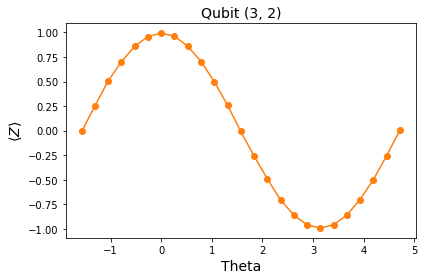

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

entry = df.iloc[0] # Pick the first qubit

plt.plot([], []) # advance color cycle in anticipation of future analysis
plt.plot(entry['thetas'], entry['z_vals'], 'o-')
plt.xlabel('Theta', fontsize=14)
plt.ylabel(r'$\langle Z \rangle$', fontsize=14)
plt.title("Qubit {}".format(entry['qubit']), fontsize=14)
plt.tight_layout()

In [ ]:
qubit = cirq.LineQubit(0)
thetas = df.iloc[0]['thetas']

class _DummyMeasurementGate(cirq.IdentityGate):
    """A dummy measurement used to trick simulators into applying
    readout error when using PauliString.expectation_from_xxx."""

    def _measurement_key_(self):
        return 'dummy!'

    def __repr__(self):
        if self.num_qubits() == 1:
            return '_DummyMeasurementGate'
        return '_DummyMeasurementGate({!r})'.format(self.num_qubits())

    def __str__(self):
        if (self.num_qubits() == 1):
            return 'dummyM'
        else:
            return 'dummyM({})'.format(self.num_qubits())

    def _circuit_diagram_info_(self, args):
        from cirq import protocols
        return protocols.CircuitDiagramInfo(
            wire_symbols=('dM',) * self.num_qubits(), connected=True)

def dummy_measure(qubits):
    return _DummyMeasurementGate(num_qubits=len(qubits)).on(*qubits)

def get_circuit(theta):
    return cirq.Circuit([
        cirq.ry(theta).on(qubit),
        dummy_measure([qubit])
    ])

true_z_vals = []
for theta in thetas:
    wf = cirq.final_state_vector(get_circuit(theta))
    op = cirq.Z(qubit) * 1.
    true_z_val = op.expectation_from_state_vector(wf, qubit_map={qubit:0}, check_preconditions=False)
    true_z_vals.append(np.real_if_close(true_z_val).item())

true_z_vals = np.array(true_z_vals)
true_z_vals

array([-1.26880515e-08,  2.58819014e-01,  5.00000000e-01,  7.07106769e-01,
        8.66025388e-01,  9.65925872e-01,  1.00000000e+00,  9.65925872e-01,
        8.66025388e-01,  7.07106769e-01,  5.00000000e-01,  2.58819014e-01,
       -1.26880515e-08, -2.58819014e-01, -4.99999970e-01, -7.07106709e-01,
       -8.66025388e-01, -9.65925872e-01, -1.00000000e+00, -9.65925872e-01,
       -8.66025388e-01, -7.07106709e-01, -4.99999970e-01, -2.58819014e-01,
       -1.26880515e-08])

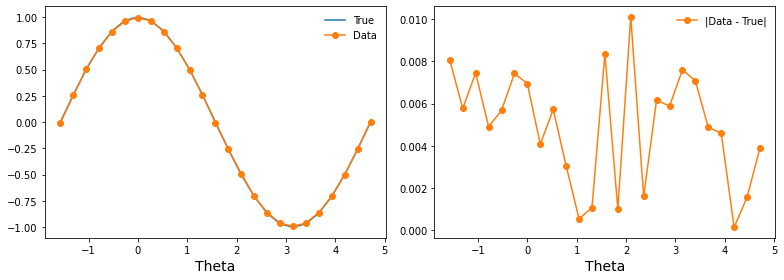

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(thetas, true_z_vals, '-', label='True')
ax1.plot(entry['thetas'], entry['z_vals'], 'o-', label='Data')

ax2.plot([], []) # advance color cycle
ax2.plot(entry['thetas'], np.abs(true_z_vals - entry['z_vals']), 'o-', label='|Data - True|')

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
ax1.set_xlabel('Theta', fontsize=14)
ax2.set_xlabel('Theta', fontsize=14)

fig.tight_layout()

In [ ]:
import scipy.optimize
import cirq.contrib.noise_models as ccn

def get_obj_func(data_expectations):
    all_results = []
    def obj_func(x):
        depol_prob, decay_prob, readout_prob = x

        if depol_prob < 0 or decay_prob < 0 or readout_prob < 0:
            # emulate constraints by returning a high cost if we
            # stray into invalid territory
            return 1000

        sim = cirq.DensityMatrixSimulator(
            noise=ccn.DepolarizingWithDampedReadoutNoiseModel(
                depol_prob=depol_prob, decay_prob=decay_prob, bitflip_prob=readout_prob))

        results = []
        for theta in thetas:            
            density_result = sim.simulate(get_circuit(theta))
            op = cirq.Z(qubit) * 1.
            true_z_val = op.expectation_from_state_vector(
                density_result.final_density_matrix, 
                qubit_map=density_result.qubit_map, check_preconditions=False)
            results.append(np.real_if_close(true_z_val).item())

        results = np.array(results)
        all_results.append(results)
        cost = np.sum(np.abs(results - data_expectations))
        return cost

    return obj_func, all_results

In [ ]:
def print_result(x):
        depol_prob, decay_prob, readout_prob = x
        print(f'depol   = {depol_prob:.2%}')
        print(f'decay   = {decay_prob:.2%}')
        print(f'readout = {readout_prob:.2%}')

In [ ]:
dfb = df
dfb = dfb.head(5) # Remove this to do all qubits
len(dfb)

5

Optimization terminated successfully.
         Current function value: 0.215544
         Iterations: 69
         Function evaluations: 135
Qubit 3, 2
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


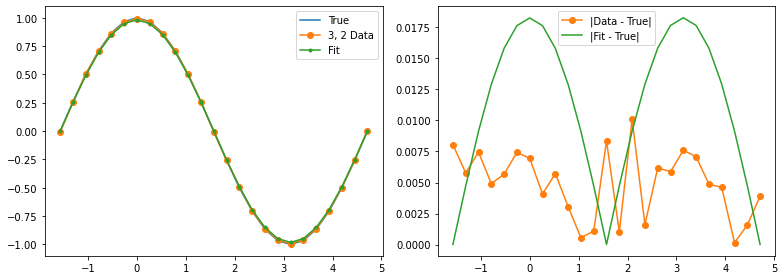

Optimization terminated successfully.
         Current function value: 0.184022
         Iterations: 63
         Function evaluations: 124
Qubit 4, 1
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


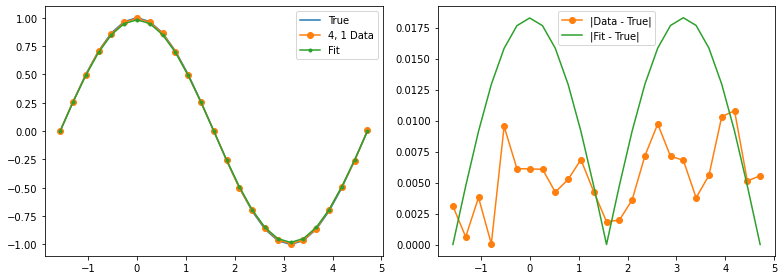

Optimization terminated successfully.
         Current function value: 0.200193
         Iterations: 57
         Function evaluations: 111
Qubit 4, 3
depol   = 1.35%
decay   = 0.00%
readout = 0.01%


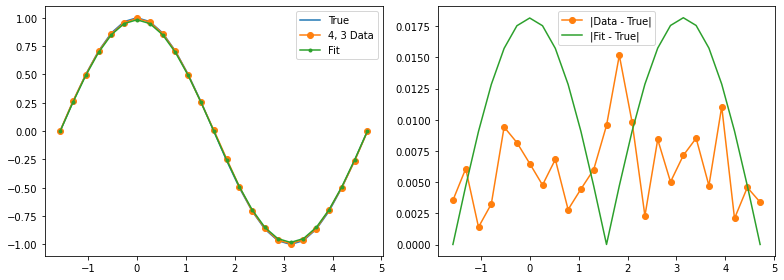

Optimization terminated successfully.
         Current function value: 0.184801
         Iterations: 69
         Function evaluations: 135
Qubit 4, 2
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


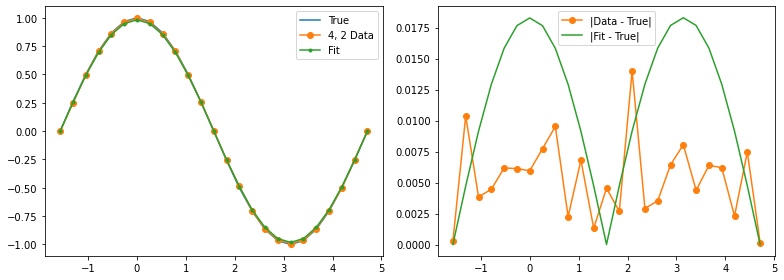

Optimization terminated successfully.
         Current function value: 0.200479
         Iterations: 59
         Function evaluations: 114
Qubit 5, 0
depol   = 1.35%
decay   = 0.00%
readout = 0.01%


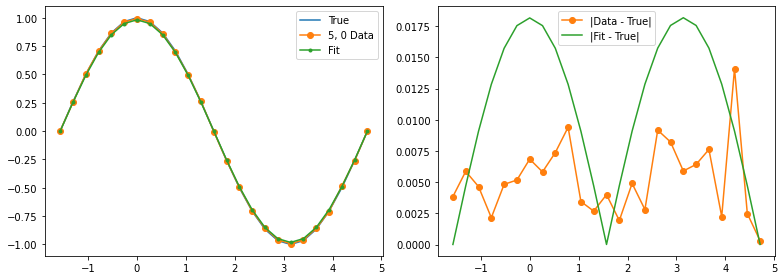

In [ ]:
# Initial values
depol_prob = 0.01
decay_prob = 0.01
readout_prob = 0.01

opt_results = []
for i, entry in dfb.iterrows():
    ofunc, results = get_obj_func(entry['z_vals'])    
    opt_result = scipy.optimize.minimize(ofunc, 
                                         [depol_prob, decay_prob, readout_prob],
                                         method='nelder-mead',
                                         options={'disp': True})
    label = f"{entry['qubit'].row}, {entry['qubit'].col}"
    print("Qubit", label)
    print_result(opt_result.x)
    opt_results.append(opt_result)

    data_expectations = entry['z_vals']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(thetas, true_z_vals, label='True')
    ax1.plot(thetas, data_expectations, 'o-', label=f'{label} Data')
    ax1.plot(thetas, results[-1], '.-', label='Fit')

    ax2.plot([], []) # advance color cycle
    ax2.plot(thetas, np.abs(true_z_vals - data_expectations), 'o-', label='|Data - True|')
    ax2.plot(thetas, np.abs(true_z_vals - results[-1]), '-', label='|Fit - True|')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()